In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2019 - 2022 United Kingdom Research and Innovation
#  Copyright 2019 - 2022 The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Evangelos Papoutsellis (UKRI-STFC)
#                   Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)     

# Primal Dual Hybrid Gradient Algorithm

In this demo, we learn how to use the **Primal Dual Hybrid Algorithm (PDHG)** introduced by [Chambolle & Pock](https://hal.archives-ouvertes.fr/hal-00490826/document) for Tomography Reconstruction. We will solve the following minimisation problem under three different regularisation terms, i.e., 

* $\|\cdot\|_{1}$ or
* Tikhonov regularisation or
* with $L=\nabla$ and Total variation:


<a id='all_reg'></a>
$$
u^{*} =\underset{u}{\operatorname{argmin}} \frac{1}{2} \| \mathcal{A} u - g\|^{2} +
\underbrace{
\begin{cases}
\alpha\,\|u\|_{1}, & \\[10pt]
\alpha\,\|\nabla u\|_{2}^{2}, & \\[10pt]
\alpha\,\mathrm{TV}(u) + \mathbb{I}_{\{u\geq 0\}}(u).
\end{cases}}_{Regularisers}
\tag{all reg}
$$

where,

1. $g$ is the Acquisition data obtained from the detector.

1. $\mathcal{A}$ is the projection operator ( _Radon transform_ ) that maps from an image-space to an acquisition space, i.e., $\mathcal{A} : \mathbb{X} \rightarrow \mathbb{Y}, $ where $\mathbb{X}$ is an __ImageGeometry__ and $\mathbb{Y}$ is an __AcquisitionGeometry__.

1. $\alpha$: regularising parameter that measures the trade-off between the fidelity and the regulariser terms.

1. The total variation (isotropic) is defined as $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$

1. $\mathbb{I}_{\{u\geq 0\}}(u) : = 
\begin{cases}
0, & \text{ if } u\geq 0\\
\infty , & \text{ otherwise}
\,
\end{cases}
$, $\quad$ a non-negativity constraint for the minimiser $u$.

# Learning objectives

- Load the data using the CIL reader: `ZEISSDataReader`.
- Preprocess the data using the CIL processors:  `Binner`, `TransmissionAbsorptionConverter`.
- Run FBP and SIRT reconstructions.
- Setup PDHG for 3 different regularisers: $L^{1}$, Tikhonov and Total variation.

<!---
1. Brief intro for non-smooth minimisation problems using PDHG algorithm.
1. Setup and run PDHG with (__non-smooth__) $L^{1}$ norm regulariser. __(No BlockFramework)__
1. Use __BlockFunction__ and __Block Framework__ to setup PDHG for Tikhonov and TV reconstructions.
1. Run Total variation reconstruction with different regularising parameters and compared with FBP and SIRT reconstructions.
    

At the end of this demo, we will be able to reproduce all the reconstructions presented in the figure below. One can observe that the __Tikhonov regularisation__ with $L = \nabla$ was able to remove the noise but could not preserve the edges. However, this can be achieved with the the total variation reconstruction.

<img src="CIL-Demos/Notebooks/images/recon_all_tomo.jpeg"  width="1500"/>
--->

<!-- <h2><center><u> Prerequisites </u></center></h2>

- AcquisitionData, AcquisitionGeometry, AstraProjectorSimple.
- BlockOperator, Gradient.
- FBP, SIRT, CGLS, Tikhonov. -->

We first import all the necessary libraries for this notebook.

<!---
In order to use the PDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

<a id='PDHG_form'></a>
$$\min_{u} \mathcal{F}(K u) + \mathcal{G}(u)$$

where we assume that:

1. $\mathcal{F}$, $\mathcal{G}$ are __convex__ functionals
    
    - $\mathcal{F}: Y \rightarrow \mathbb{R}$ 
    
    - $\mathcal{G}: X \rightarrow \mathbb{R}$
    
    
2. $K$ is a continuous linear operator acting from a space X to another space Y :

$$K : X \rightarrow Y \quad $$ 

with operator norm  defined as $$\| K \| = \max\{ \|K x\|_{Y} : \|x\|_{X}\leq 1 \}.$$  

**Note**: The Gradient operator  has  $\|\nabla\| = \sqrt{8} $ and for the projection operator we use the [Power Method](https://en.wikipedia.org/wiki/Power_iteration) to approximate the greatest eigenvalue of $K$.

--->

In [3]:
# Import libraries

from cil.framework import BlockDataContainer

from cil.optimisation.functions import L2NormSquared, L1Norm, BlockFunction, MixedL21Norm, IndicatorBox
from TotalVariation import TotalVariation
from TotalVariationNew import TotalVariationNew
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG, SIRT

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP

from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.utilities.display import show2D, show1D, show_geometry
from cil.utilities.jupyter import islicer

from cil.io import ZEISSDataReader

from cil.processors import Binner, TransmissionAbsorptionConverter, Slicer

import matplotlib.pyplot as plt

import numpy as np

import os

# Data information

In this demo, we use the **Walnut** found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8). In total, there are 6 individual micro Computed Tomography datasets in the native Zeiss TXRM/TXM format. The six datasets were acquired at the 3D Imaging Center at Technical University of Denmark in 2014 (HDTomo3D in 2016) as part of the ERC-funded project High-Definition Tomography (HDTomo) headed by Prof. Per Christian Hansen. 

This example requires the dataset walnut.zip from https://zenodo.org/record/4822516 :

 - https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the `path` variable below.

## Load walnut data

In [4]:
path = '../../../data/'

In [5]:
reader = ZEISSDataReader()
filename = os.path.join(path, "valnut_tomo-A.txrm")
data3D = ZEISSDataReader(file_name=filename).read()

In [6]:
# reorder data to match default order for Astra/Tigre operator
data3D.reorder('astra')

# Get Image and Acquisition geometries
ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()

### Acquisition and Image geometry information

In [7]:
print(ag3D)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -105.05081177,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 45.08757401,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1024 1024]
	Pixel size: [0.0658543 0.0658543]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1601
	Angles 0-20 in radians:
[-3.1415665, -3.1377017, -3.1337626, -3.1298182, -3.125836 , -3.1219127,
 -3.1180956, -3.1140666, -3.1101887, -3.1062822, -3.1022923, -3.0984268,
 -3.0944946, -3.0905435, -3.0865552, -3.082691 , -3.0787866, -3.074828 ,
 -3.0708766, -3.0669732]
Distances in units: units distance


In [8]:
print(ig3D)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x1024,y1024,z1024
voxel_size : x0.04607780456542968,y0.04607780456542968,z0.04607780456542968
center : x0,y0,z0



### Show Acquisition geometry and full 3D sinogram.

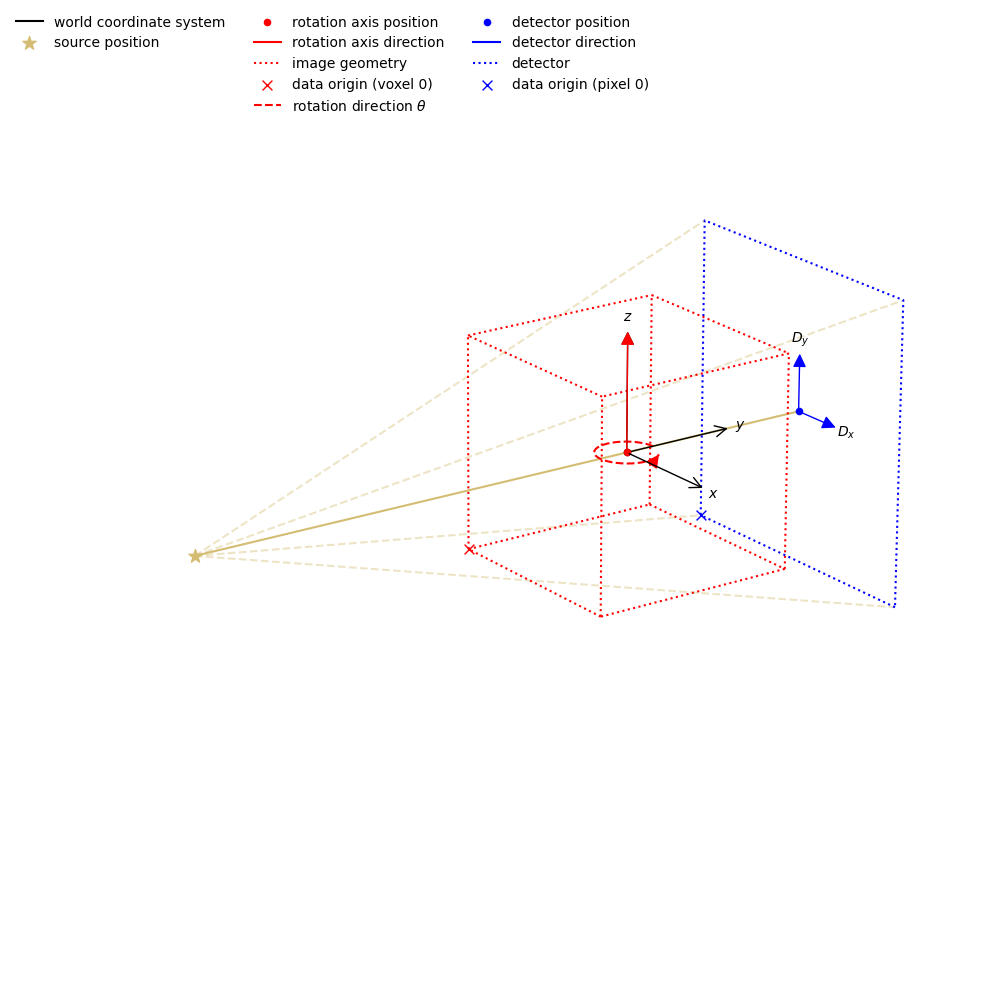

In [9]:
show_geometry(ag3D)

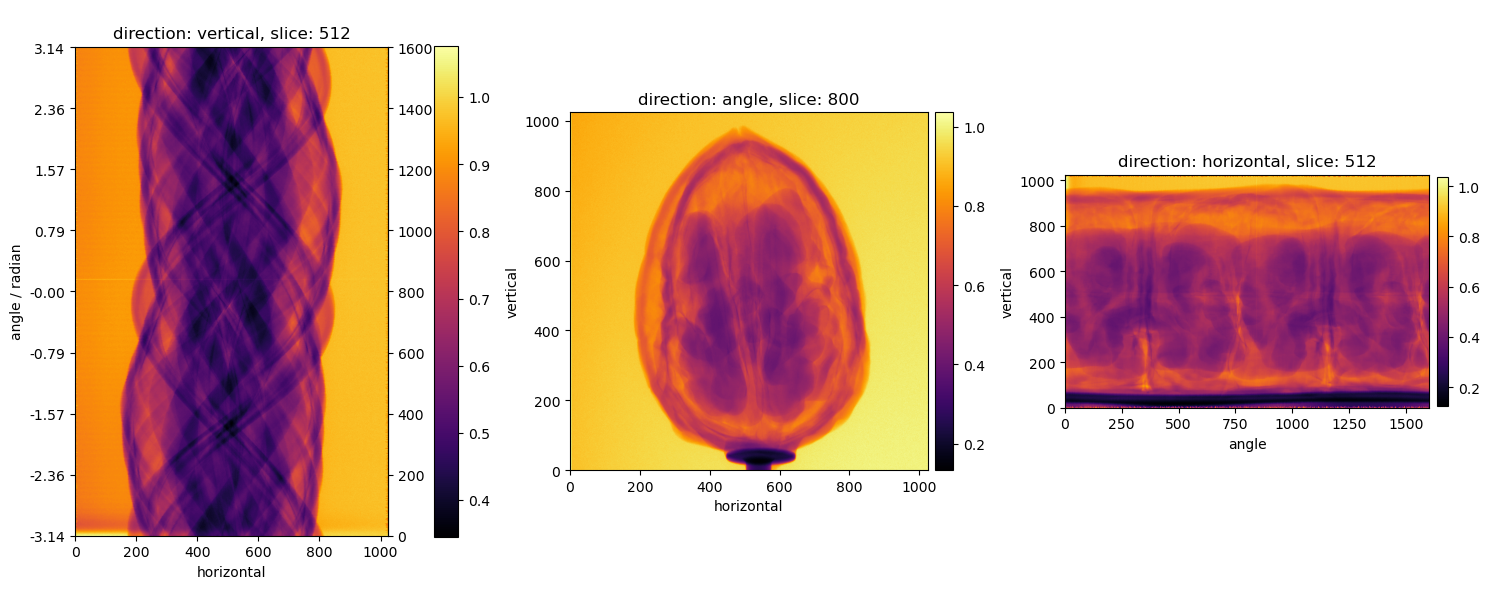

In [10]:
show2D(data3D, slice_list = [('vertical',512), ('angle',800), ('horizontal',512)], cmap="inferno", num_cols=3, size=(15,15))

### Slice through projections

In [11]:
islicer(data3D, direction=1, cmap="inferno")

### For demonstration purposes, we extract the central slice and select only 160 angles from the total 1601 angles.

1. We use the `Slicer` processor with step size of 10.
1. We use the `Binner` processor to crop and bin the acquisition data in order to reduce the field of view.
1. We use the `TransmissionAbsorptionConverter` to convert from transmission measurements to absorption based on the Beer-Lambert law.

**Note:** To avoid circular artifacts in the reconstruction space, we subtract the mean value of a background Region of interest (ROI), i.e., ROI that does not contain the walnut.

In [12]:
# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1600,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
absorption_data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
absorption_data -= np.mean(absorption_data.as_array()[80:100,0:30])

#Add some gaussian noise 
absorption_data+=np.random.normal(0, 0.1*np.mean(absorption_data))

In [13]:
# Get Image and Acquisition geometries for one slice
ag2D = absorption_data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

In [14]:
print(" Acquisition Geometry 2D: {} with labels {}".format(ag2D.shape, ag2D.dimension_labels))
print(" Image Geometry 2D: {} with labels {}".format(ig2D.shape, ig2D.dimension_labels))

 Acquisition Geometry 2D: (160, 392) with labels ('angle', 'horizontal')
 Image Geometry 2D: (392, 392) with labels ('horizontal_y', 'horizontal_x')


### Define Projection Operator 
We can define our projection operator using our __astra__ __plugin__ that wraps the Astra-Toolbox library.

In [15]:
A = ProjectionOperator(ig2D, ag2D, device = "gpu")

## FBP and SIRT reconstructions



For SIRT, we type

    
```python
    
    x_init = ig.allocate()
    sirt = SIRT(initial = x_init, operator = A, data=absorption_data, 
            max_iteration = 50, update_objective_interval=10)
    sirt.run(verbose=1)
    sirt_recon = sirt.solution 
       
```

**Note**: In SIRT, a non-negative constraint can be used with


```python    
    
    constraint=IndicatorBox(lower=0)        
    
```
   

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        300         0.000          1.55715e+04
      100        300         0.014          4.45201e+01
      200        300         0.013          4.08036e+01
      300        300         0.013          4.01081e+01
-------------------------------------------------------
      300        300         0.013          4.01081e+01
Stop criterion has been reached.



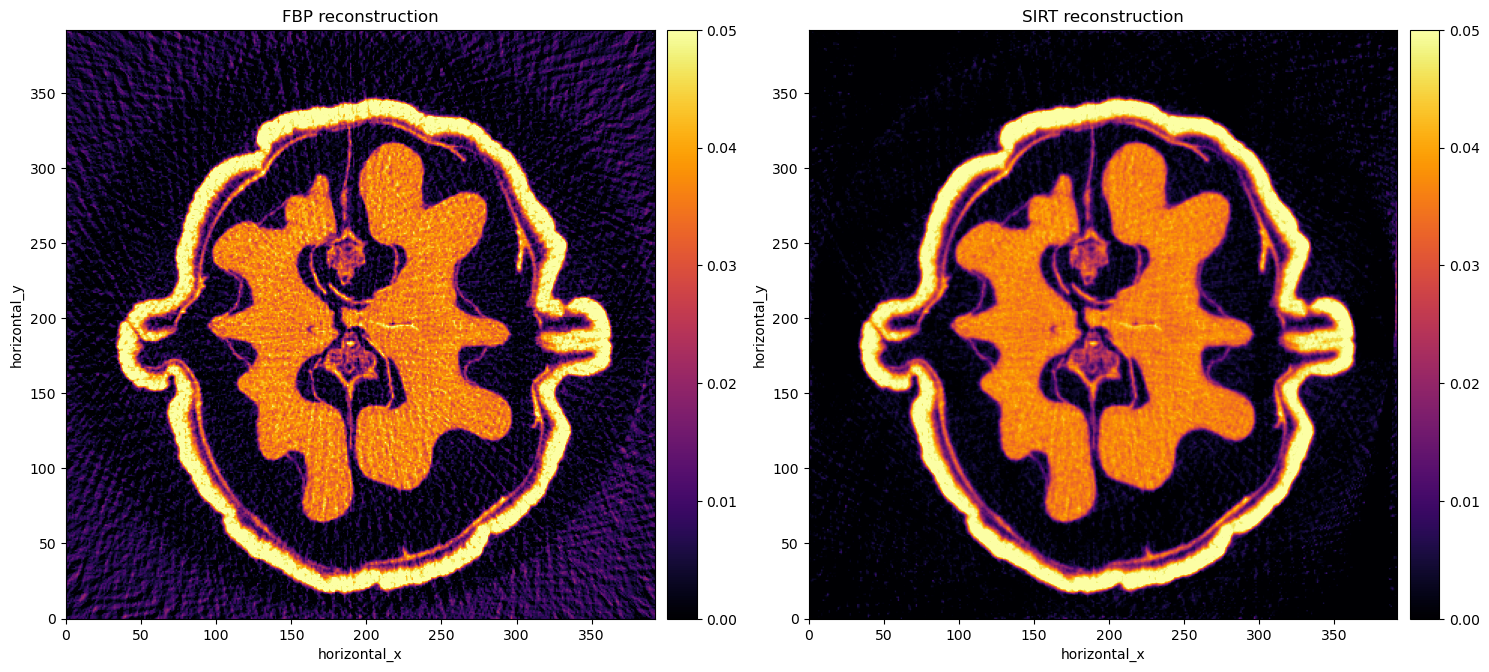

In [16]:
# Setup and run the FBP algorithm
fbp_recon = FBP(ig2D, ag2D,  device = 'gpu')(absorption_data)

# Setup and run the SIRT algorithm, with  non-negative constraint
x_init = ig2D.allocate()  
sirt = SIRT(initial = x_init, 
            operator = A, 
            data= absorption_data, 
            constraint = IndicatorBox(lower=0),
            max_iteration = 300, 
            update_objective_interval=100)
sirt.run(verbose=1)
sirt_recon = sirt.solution

# Show reconstructions
show2D([fbp_recon,sirt_recon], 
       title = ['FBP reconstruction','SIRT reconstruction'], 
       cmap = 'inferno', fix_range=(0,0.05))


## L1 regularisation

In [17]:
K = A
F = 0.5 * L2NormSquared(b=absorption_data)
alpha = 0.01
G = alpha * L1Norm()

In [18]:
# Setup and run PDHG
pdhg_l1 = PDHG(f = F, g = G, operator = K, 
            max_iteration = 100,
            update_objective_interval = 5)
pdhg_l1.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          7.78577e+03
        5        100         0.034          1.50180e+02
       10        100         0.032          8.52854e+01
       15        100         0.032          7.65529e+01
       20        100         0.032          5.54302e+01
       25        100         0.031          4.79527e+01
       30        100         0.031          4.33529e+01
       35        100         0.031          4.14671e+01
       40        100         0.031          4.01212e+01
       45        100         0.031          3.94013e+01
       50        100         0.031          3.89588e+01
       55        100         0.030          3.86049e+01
       60        100         0.030          3.83583e+01
       65        100         0.030          3.82043e+01
       70        100         0.030          3.80932e+01
       75        100         0.030          3.80

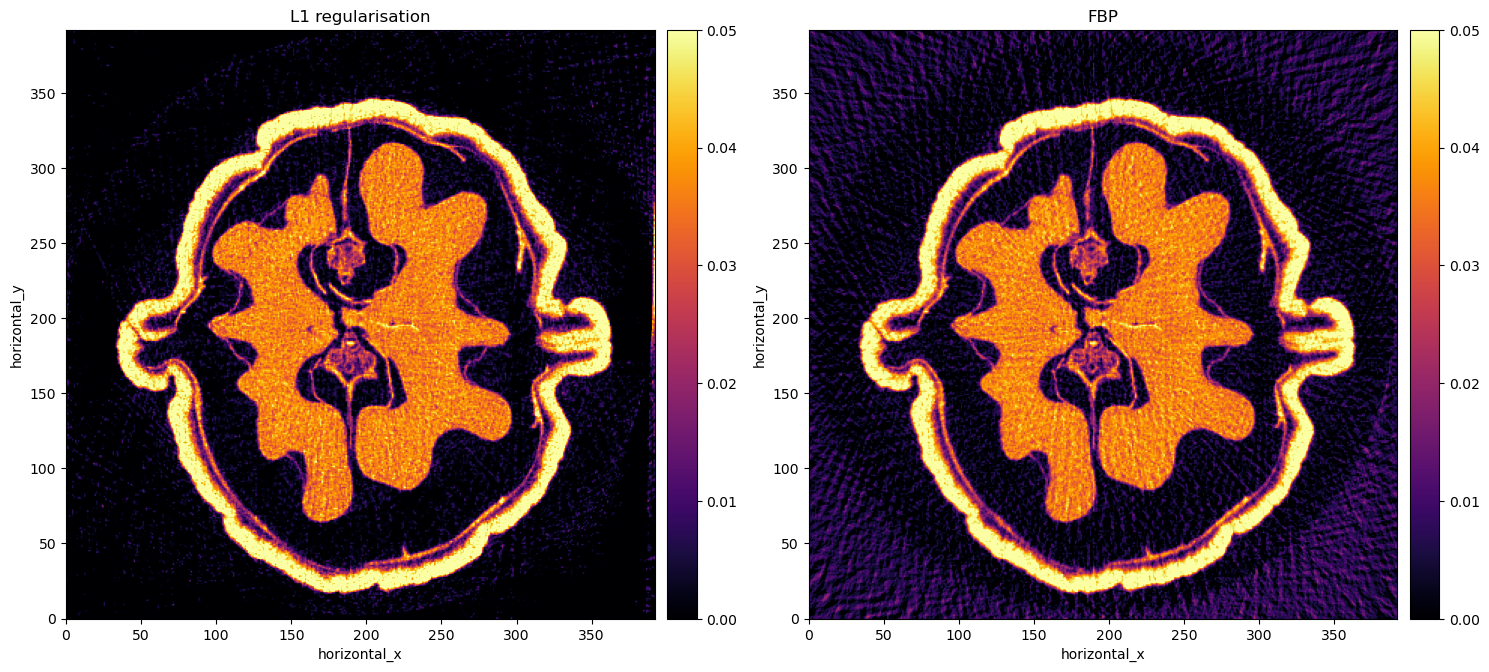

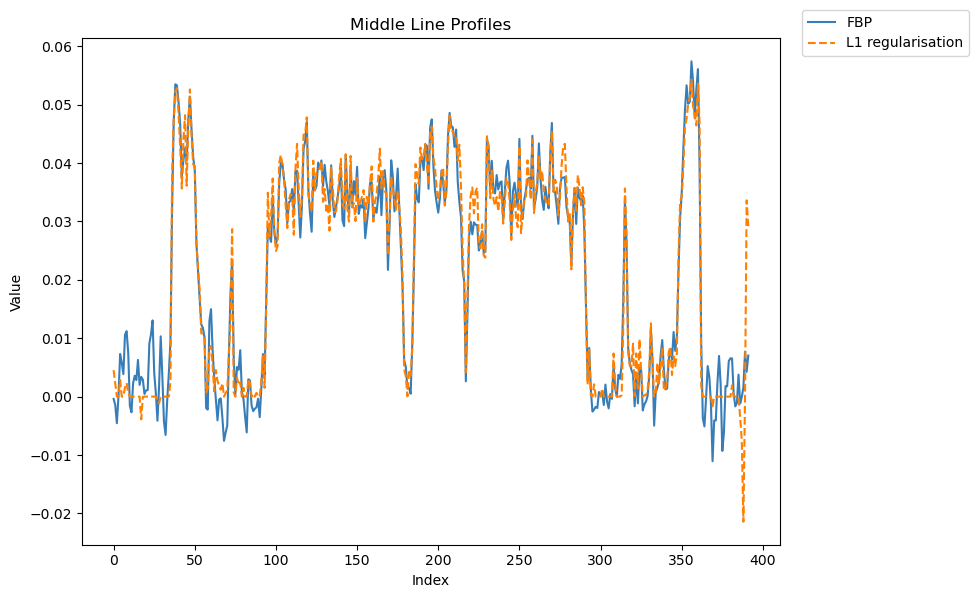

In [19]:
# Show reconstruction and ground truth
show2D([pdhg_l1.solution,fbp_recon], fix_range=(0,0.05), title = ['L1 regularisation', 'FBP'], cmap = 'inferno')

# Plot middle line profile
show1D([fbp_recon,pdhg_l1.solution], slice_list=[('horizontal_y',int(ig2D.voxel_num_y/2))],
       label = ['FBP','L1 regularisation'], title='Middle Line Profiles')


## PDHG - explicit TV 



In [20]:
# Define BlockFunction F
alpha_tv = 0.03
f1 = alpha_tv * MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption_data)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = GradientOperator(ig2D)
K = BlockOperator(Grad, A)

# Define Function G
G = IndicatorBox(lower=0)


# Setup and run PDHG
pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
            max_iteration = 100,
            update_objective_interval = 5)
pdhg_tv_explicit.run(verbose=1)

/opt/conda/envs/cil/lib/python3.10/site-packages/cil/optimisation/algorithms/PDHG.py:408: UserWarning: Convergence criterion of PDHG for scalar step-sizes is not satisfied.
  warnings.warn("Convergence criterion of PDHG for scalar step-sizes is not satisfied.")


     Iter   Max Iter     Time/Iter            Objective
                               [s]                     


        0        100         0.000          7.78577e+03
        5        100         0.126          9.23442e+02
       10        100         0.097          1.45957e+02
       15        100         0.083          1.01186e+02
       20        100         0.077          1.25176e+02
       25        100         0.074          1.04697e+02
       30        100         0.074          9.57346e+01
       35        100         0.072          9.31786e+01
       40        100         0.069          9.51080e+01
       45        100         0.068          1.00851e+02
       50        100         0.067          9.68549e+01
       55        100         0.067          9.25427e+01
       60        100         0.067          8.77503e+01
       65        100         0.067          8.43901e+01
       70        100         0.066          8.31915e+01
       75        100         0.065          8.34591e+01
       80        100         0.064          8.33401e+01
       85        100         0.064          8.17

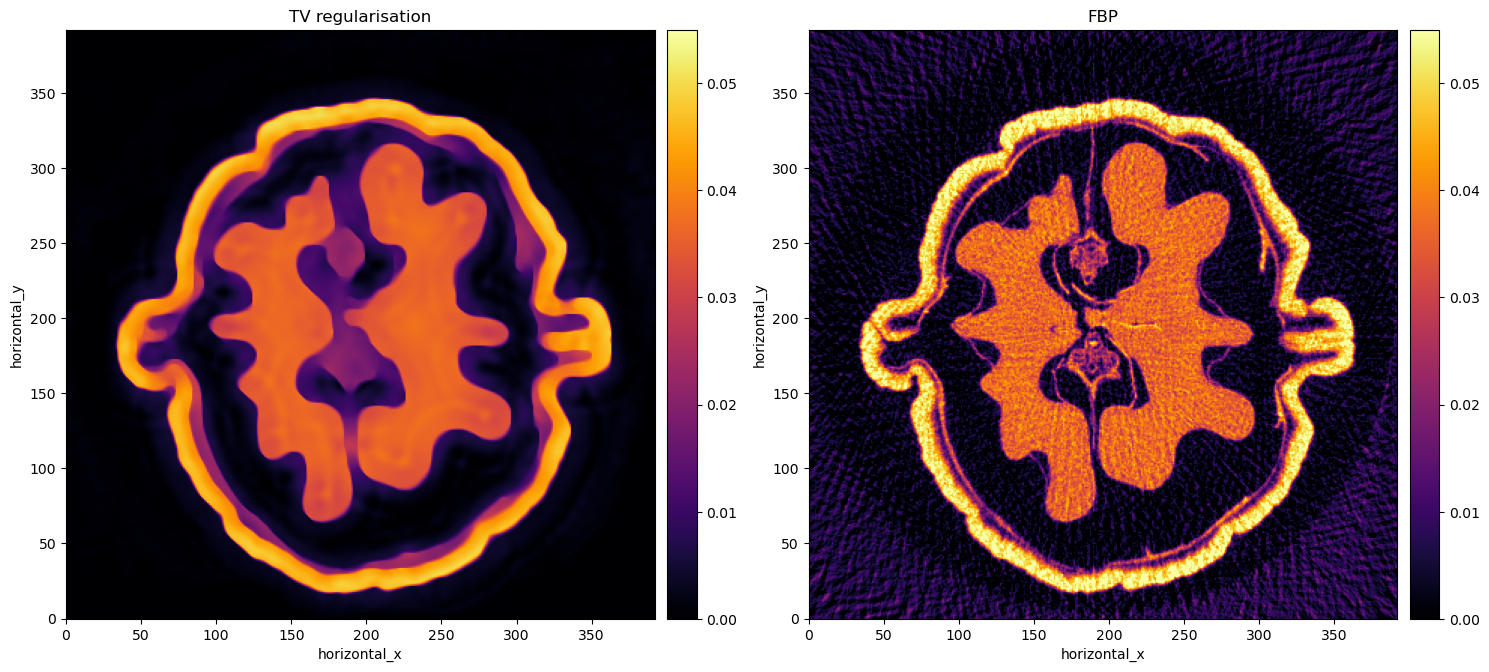

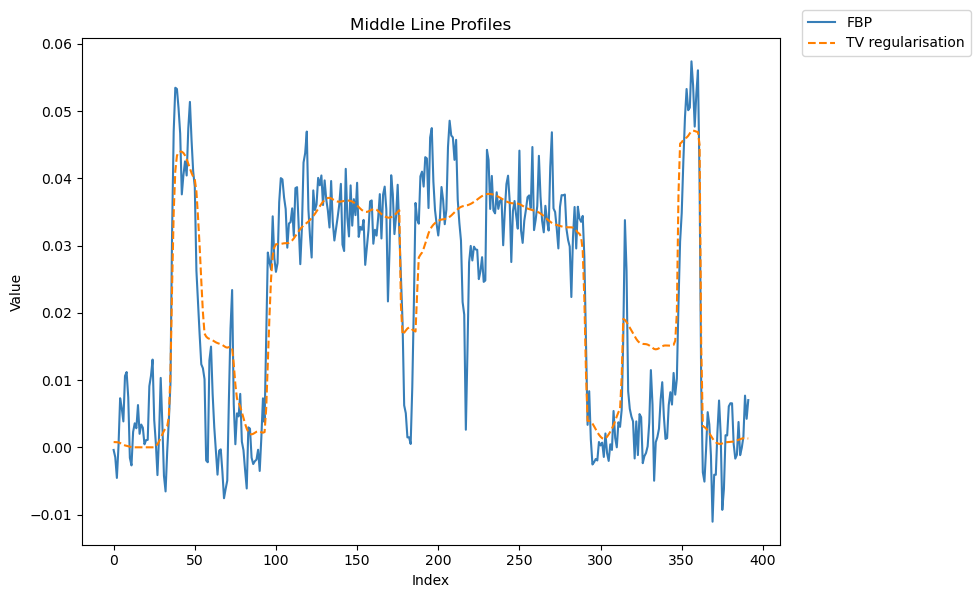

In [21]:
# Show reconstruction and ground truth
show2D([pdhg_tv_explicit.solution,fbp_recon], fix_range=(0,0.055), title = ['TV regularisation','FBP'], cmap = 'inferno')

# Plot middle line profile
show1D([fbp_recon,pdhg_tv_explicit.solution], slice_list=[('horizontal_y',int(ig2D.voxel_num_y/2))],
       label = ['FBP','TV regularisation'], title='Middle Line Profiles')

## PDHG - implicit TV (using CIL)

In [22]:
F = 0.5 * L2NormSquared(b=absorption_data)
G = alpha_tv * TotalVariation(max_iteration=100, lower=0.)
K = A
# Setup and run PDHG
pdhg_tv_implicit_cil = PDHG(f = F, g = G, operator = K,
            max_iteration = 200,
            update_objective_interval = 5)
pdhg_tv_implicit_cil.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          7.78577e+03


        5        200         0.341          2.14478e+02
       10        200         0.338          1.01980e+02
       15        200         0.335          9.46818e+01
       20        200         0.334          8.41993e+01
       25        200         0.335          7.65870e+01


## PDHG - implicit TV (using CIL) with warm start 

In [ ]:
F = 0.5 * L2NormSquared(b=absorption_data)
G = alpha_tv * TotalVariation(max_iteration=5, lower=0., warmstart=True)
K = A
# Setup and run PDHG
pdhg_tv_implicit_cil_warm_start = PDHG(f = F, g = G, operator = K,
            max_iteration = 200,
            update_objective_interval = 5)
pdhg_tv_implicit_cil_warm_start.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          8.25015e+03
        5        200         0.352          1.60544e+02
       10        200         0.312          1.06617e+02
       15        200         0.287          9.13544e+01
       20        200         0.277          8.61812e+01
       25        200         0.269          8.44414e+01
       30        200         0.265          7.77769e+01
       35        200         0.233          7.52128e+01
       40        200         0.208          7.40621e+01
       45        200         0.188          7.33470e+01
       50        200         0.172          7.31991e+01
       55        200         0.159          7.27236e+01
       60        200         0.148          7.23118e+01
       65        200         0.139          7.19699e+01
       70        200         0.131          7.18211e+01
       75        200         0.125          7.17

## PDHG - implicit TV (using FGP_TV)

In [ ]:
F = 0.5 * L2NormSquared(b=absorption_data)
G = (alpha_tv/ig2D.voxel_size_y) * FGP_TV(max_iteration=100, nonnegativity = True, device = 'gpu') 
K = A

# Setup and run PDHG
pdhg_tv_implicit_regtk = PDHG(f = F, g = G, operator = K,
            max_iteration = 200,
            update_objective_interval = 5)
pdhg_tv_implicit_regtk.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          8.25015e+03
        5        200         0.067          2.15057e+02
       10        200         0.060          1.06399e+02
       15        200         0.060          1.00500e+02
       20        200         0.059          8.48420e+01
       25        200         0.058          7.63590e+01
       30        200         0.058          7.46227e+01
       35        200         0.058          7.34176e+01
       40        200         0.057          7.24497e+01
       45        200         0.056          7.22147e+01
       50        200         0.055          7.19124e+01
       55        200         0.055          7.17686e+01
       60        200         0.053          7.17588e+01
       65        200         0.051          7.17218e+01
       70        200         0.053          7.16818e+01
       75        200         0.052          7.16

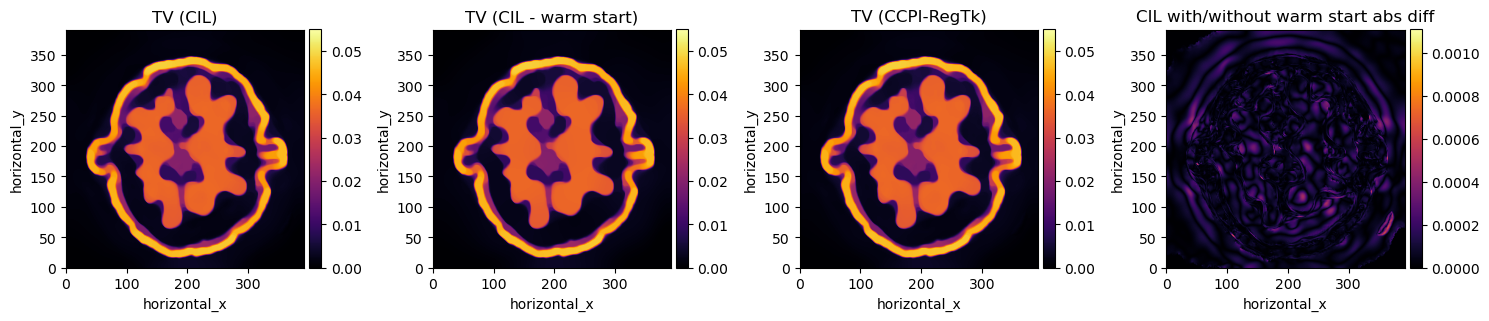

[8250.154296875, 215.05657196044922, 106.39899444580078, 100.50038146972656, 84.84200286865234, 76.35898971557617, 74.62270164489746, 73.41760063171387, 72.44966888427734, 72.21465110778809, 71.91238403320312, 71.76856422424316, 71.7587661743164, 71.72175598144531, 71.68183326721191, 71.66242218017578, 71.65394592285156, 71.65480422973633, 71.65475654602051, 71.6554946899414, 71.65569305419922, 71.65365600585938, 71.65217971801758, 71.65153503417969, 71.65173149108887, 71.65171813964844, 71.65239334106445, 71.65228271484375, 71.65267181396484, 71.6526985168457, 71.65258026123047, 71.65302658081055, 71.65312576293945, 71.65282440185547, 71.6523551940918, 71.65185928344727, 71.65185356140137, 71.65224838256836, 71.6529312133789, 71.65275955200195, 71.6528549194336]
[8250.154296875, 215.0452215576172, 106.40082824707031, 100.50085388183594, 84.83776733398437, 76.3432186126709, 74.61869659423829, 73.41623825073242, 72.4344546508789, 72.21051956176757, 71.9094467163086, 71.75964500427246, 7

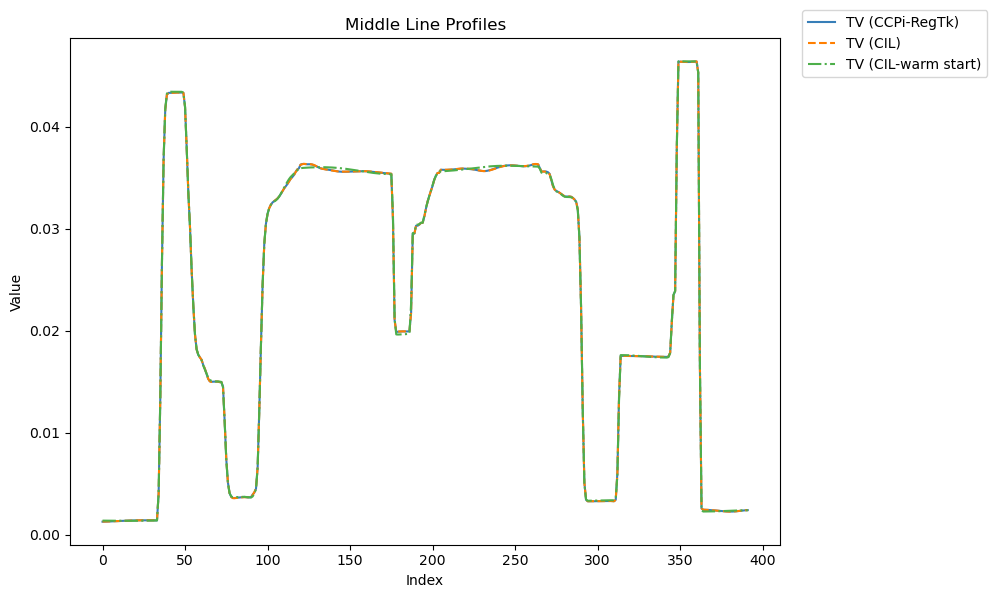

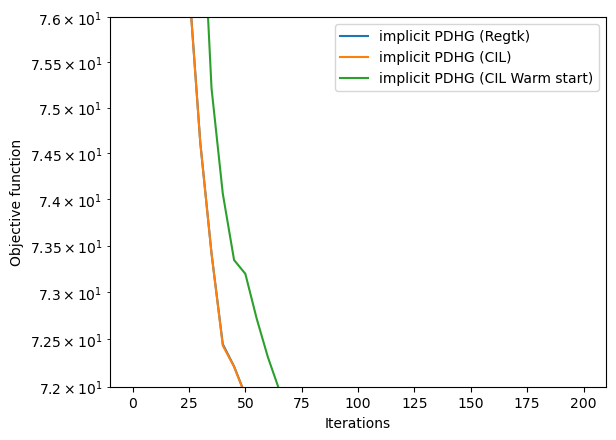

In [ ]:
# Show reconstruction and ground truth
show2D([pdhg_tv_implicit_regtk.solution,
        pdhg_tv_implicit_cil_warm_start.solution,
        pdhg_tv_implicit_cil.solution,
        (pdhg_tv_implicit_cil.solution-pdhg_tv_implicit_cil_warm_start.solution).abs()], 
       fix_range=[(0,0.055),(0,0.055),(0,0.055), None], num_cols=4,
       title = ['TV (CIL)','TV (CIL - warm start)', 'TV (CCPI-RegTk)', 'CIL with/without warm start abs diff' ], 
       cmap = 'inferno')

# Plot middle line profile
show1D([pdhg_tv_implicit_regtk.solution,pdhg_tv_implicit_cil.solution, pdhg_tv_implicit_cil_warm_start.solution], slice_list=[('horizontal_y',int(ig2D.voxel_num_y/2))],
       label = ['TV (CCPi-RegTk)','TV (CIL)', 'TV (CIL-warm start)'], title='Middle Line Profiles')

print(pdhg_tv_implicit_regtk.objective)
print(pdhg_tv_implicit_cil.objective)
print(pdhg_tv_implicit_cil_warm_start.objective)

plt.figure()
iter_range = np.arange(0,201,5)
plt.semilogy(iter_range, pdhg_tv_implicit_regtk.objective, label='implicit PDHG (Regtk)')
plt.semilogy(iter_range, pdhg_tv_implicit_cil.objective, label='implicit PDHG (CIL)')
plt.semilogy(iter_range, pdhg_tv_implicit_cil_warm_start.objective, label='implicit PDHG (CIL Warm start)')
plt.xlabel('Iterations')
plt.ylabel('Objective function')
plt.ylim(72,76)
plt.legend()
plt.show()

# Using the new TV algorithm 

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          8.25015e+03
        5        200         0.386          1.59514e+02
       10        200         0.344          1.06752e+02
       15        200         0.344          9.22994e+01
       20        200         0.359          8.69552e+01
       25        200         0.357          8.52592e+01
       30        200         0.318          7.83722e+01
       35        200         0.282          7.57001e+01
       40        200         0.255          7.45419e+01
       45        200         0.234          7.37365e+01
       50        200         0.217          7.36406e+01
       55        200         0.208          7.30252e+01
       60        200         0.230          7.25427e+01
       65        200         0.239          7.21293e+01
       70        200         0.245          7.19639e+01
       75        200         0.254          7.19

        5        200         3.648          2.15057e+02
       10        200         5.501          1.06400e+02
       15        200         4.994          1.00505e+02
       20        200         4.657          8.48434e+01
       25        200         4.453          7.63598e+01
       30        200         4.478          7.46223e+01
       35        200         4.255          7.34199e+01
       40        200         4.209          7.24493e+01
       45        200         4.214          7.22161e+01
       50        200         4.071          7.19141e+01
       55        200         4.089          7.17703e+01
       60        200         4.178          7.17607e+01
       65        200         4.412          7.17240e+01
       70        200         4.422          7.16834e+01
       75        200         4.375          7.16634e+01
       80        200         4.336          7.16552e+01
       85        200         4.316          7.16558e+01
       90        200         4.271          7.16

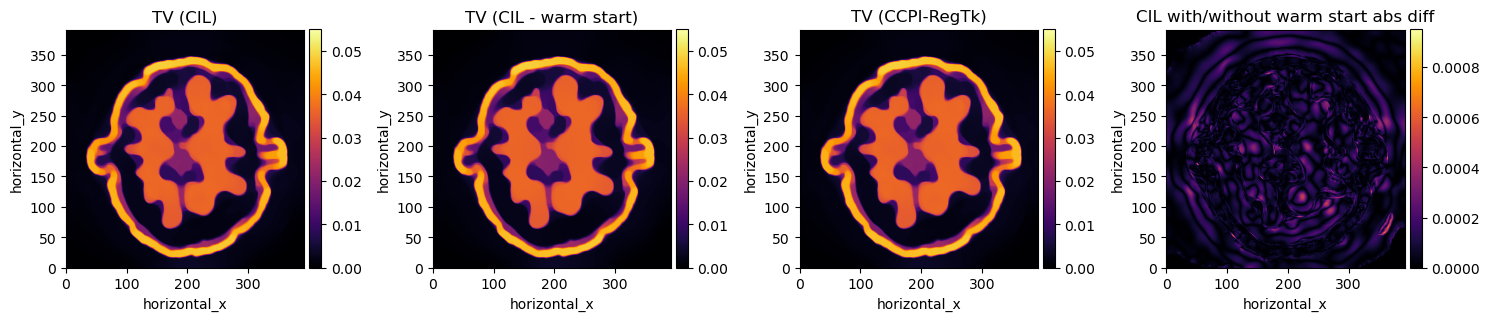

[8250.154296875, 215.05657196044922, 106.39899444580078, 100.50038146972656, 84.84200286865234, 76.35898971557617, 74.62270164489746, 73.41760063171387, 72.44966888427734, 72.21465110778809, 71.91238403320312, 71.76856422424316, 71.7587661743164, 71.72175598144531, 71.68183326721191, 71.66242218017578, 71.65394592285156, 71.65480422973633, 71.65475654602051, 71.6554946899414, 71.65569305419922, 71.65365600585938, 71.65217971801758, 71.65153503417969, 71.65173149108887, 71.65171813964844, 71.65239334106445, 71.65228271484375, 71.65267181396484, 71.6526985168457, 71.65258026123047, 71.65302658081055, 71.65312576293945, 71.65282440185547, 71.6523551940918, 71.65185928344727, 71.65185356140137, 71.65224838256836, 71.6529312133789, 71.65275955200195, 71.6528549194336]
[8250.154296875, 215.05661254882813, 106.39971313476562, 100.50492645263671, 84.84335174560547, 76.35976745605468, 74.62234169006348, 73.41988876342774, 72.44928848266602, 72.21606185913086, 71.91408226013183, 71.7703497314453

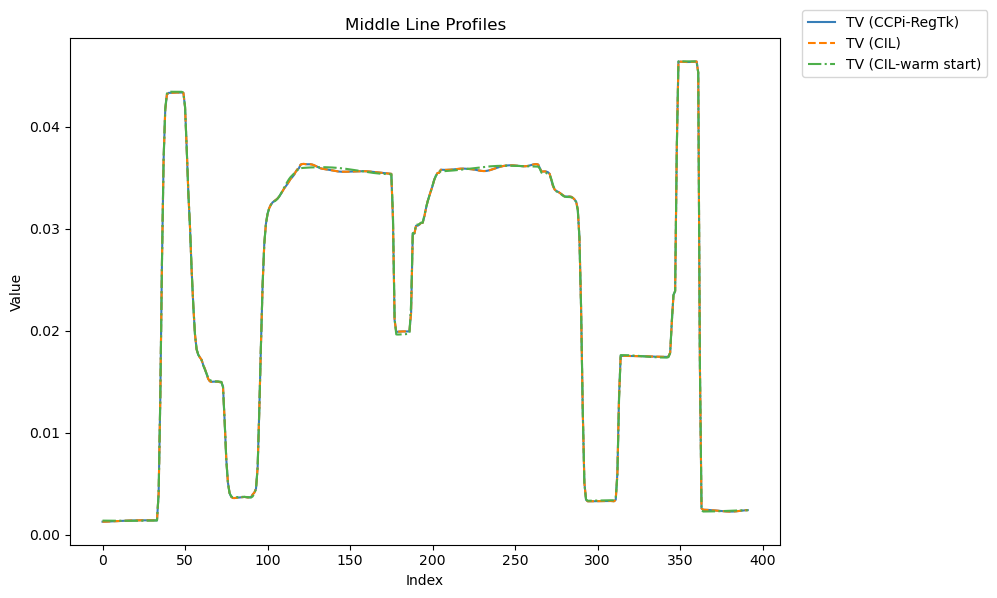

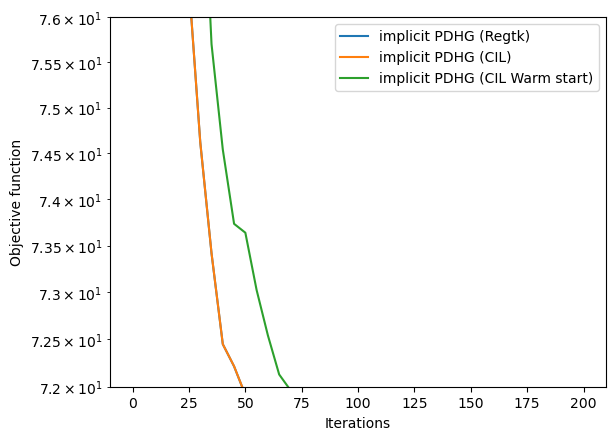

In [ ]:
F = 0.5 * L2NormSquared(b=absorption_data)
G = alpha_tv * TotalVariationNew(max_iteration=5, lower=0., warmstart=True)
K = A
# Setup and run PDHG
pdhg_tv_implicit_cil_warm_start = PDHG(f = F, g = G, operator = K,
            max_iteration = 200,
            update_objective_interval = 5)
pdhg_tv_implicit_cil_warm_start.run(verbose=1)

F = 0.5 * L2NormSquared(b=absorption_data)
G = alpha_tv * TotalVariationNew(max_iteration=100, lower=0.)
K = A
# Setup and run PDHG
pdhg_tv_implicit_cil = PDHG(f = F, g = G, operator = K,
            max_iteration = 200,
            update_objective_interval = 5)
pdhg_tv_implicit_cil.run(verbose=1)

# Show reconstruction and ground truth
show2D([pdhg_tv_implicit_regtk.solution,
        pdhg_tv_implicit_cil_warm_start.solution,
        pdhg_tv_implicit_cil.solution,
        (pdhg_tv_implicit_cil.solution-pdhg_tv_implicit_cil_warm_start.solution).abs()], 
       fix_range=[(0,0.055),(0,0.055),(0,0.055), None], num_cols=4,
       title = ['TV (CIL)','TV (CIL - warm start)', 'TV (CCPI-RegTk)', 'CIL with/without warm start abs diff' ], 
       cmap = 'inferno')

# Plot middle line profile
show1D([pdhg_tv_implicit_regtk.solution,pdhg_tv_implicit_cil.solution, pdhg_tv_implicit_cil_warm_start.solution], slice_list=[('horizontal_y',int(ig2D.voxel_num_y/2))],
       label = ['TV (CCPi-RegTk)','TV (CIL)', 'TV (CIL-warm start)'], title='Middle Line Profiles')

print(pdhg_tv_implicit_regtk.objective)
print(pdhg_tv_implicit_cil.objective)
print(pdhg_tv_implicit_cil_warm_start.objective)

plt.figure()
iter_range = np.arange(0,201,5)
plt.semilogy(iter_range, pdhg_tv_implicit_regtk.objective, label='implicit PDHG (Regtk)')
plt.semilogy(iter_range, pdhg_tv_implicit_cil.objective, label='implicit PDHG (CIL)')
plt.semilogy(iter_range, pdhg_tv_implicit_cil_warm_start.objective, label='implicit PDHG (CIL Warm start)')
plt.xlabel('Iterations')
plt.ylabel('Objective function')
plt.ylim(72,76)
plt.legend()
plt.show()

# Trying different number of inner iterations for warm start 

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        400         0.000          8.25015e+03
       50        400         0.062          7.19124e+01
      100        400         0.059          7.16557e+01
      150        400         0.054          7.16526e+01
      200        400         0.051          7.16529e+01
      250        400         0.048          7.16532e+01
      300        400         0.046          7.16531e+01
      350        400         0.046          7.16532e+01
      400        400         0.047          7.16532e+01
-------------------------------------------------------
      400        400         0.047          7.16532e+01
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        400         0.000          8.25015e+03
       50        400         1.643          7.19094e+01
      100     

ValueError: x and y must have same first dimension, but have shapes (81,) and (9,)

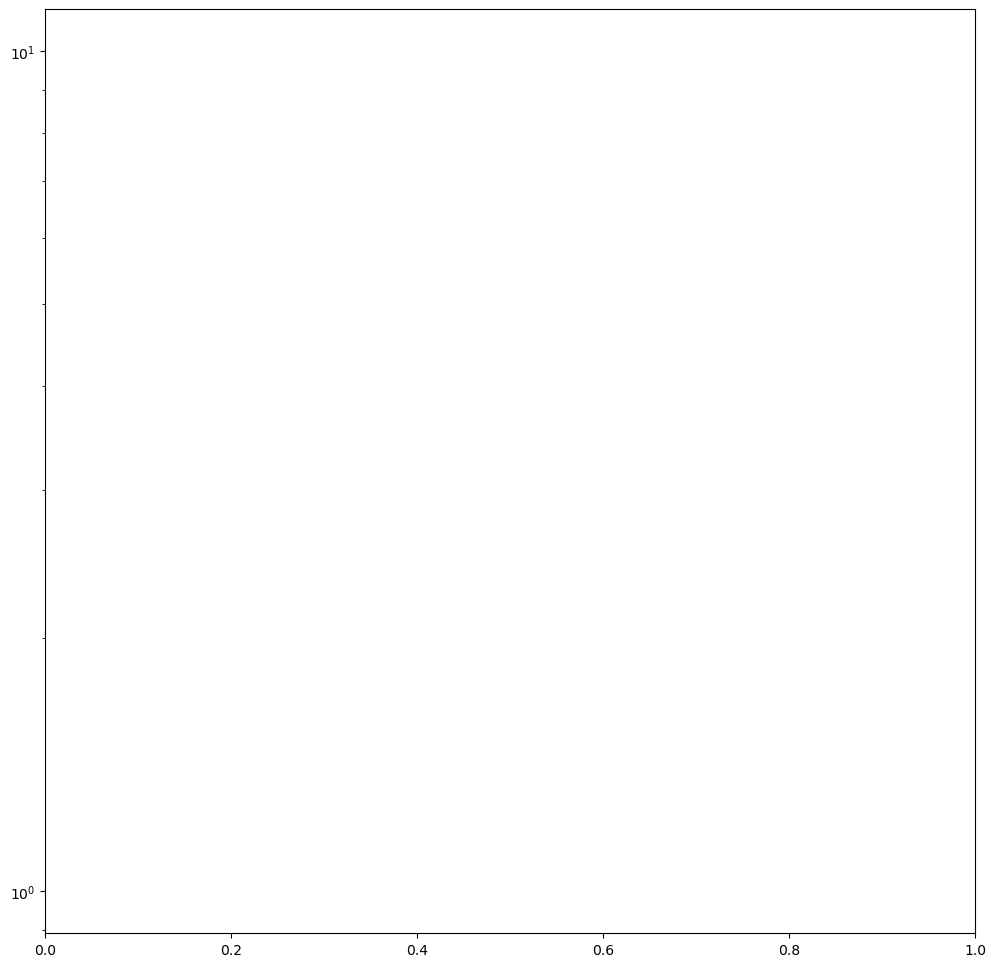

In [ ]:
F = 0.5 * L2NormSquared(b=absorption_data)
G = (alpha_tv/ig2D.voxel_size_y) * FGP_TV(max_iteration=100, nonnegativity = True, device = 'gpu') 
K = A

# Setup and run PDHG
pdhg_tv_implicit_regtk = PDHG(f = F, g = G, operator = K,
            max_iteration = 400,
            update_objective_interval = 5)
pdhg_tv_implicit_regtk.run(verbose=1)


F = 0.5 * L2NormSquared(b=absorption_data)
G = alpha_tv * TotalVariation(max_iteration=100, lower=0.)
K = A
# Setup and run PDHG
pdhg_tv_implicit_cil = PDHG(f = F, g = G, operator = K,
            max_iteration = 400,
            update_objective_interval = 5)
pdhg_tv_implicit_cil.run(verbose=1)



F = 0.5 * L2NormSquared(b=absorption_data)

K = A
plt.figure(figsize=(12,12))
iter_range = np.arange(0,401,5)
plt.semilogy(iter_range, pdhg_tv_implicit_regtk.objective, label='implicit PDHG (Regtk)')
plt.semilogy(iter_range, pdhg_tv_implicit_cil.objective, label='implicit PDHG (CIL)')
for i in range(0,30,2):
    G = alpha_tv * TotalVariation(max_iteration=i, lower=0., warmstart=True)
    # Setup and run PDHG
    pdhg_tv_implicit_cil_warm_start = PDHG(f = F, g = G, operator = K,
                max_iteration = 400,
                update_objective_interval = 5)
    pdhg_tv_implicit_cil_warm_start.run(verbose=1)



    plt.semilogy(iter_range, pdhg_tv_implicit_cil_warm_start.objective, label='implicit PDHG (CIL Warm start '+str(i)+' iterations')
plt.xlabel('Iterations')
plt.ylabel('Objective function')
plt.ylim(70,76)
plt.legend()
plt.show()



In [ ]:
F = 0.5 * L2NormSquared(b=absorption_data)
G = (alpha_tv/ig2D.voxel_size_y) * FGP_TV(max_iteration=100, nonnegativity = True, device = 'gpu') 
K = A

# Setup and run PDHG
pdhg_tv_implicit_regtk = PDHG(f = F, g = G, operator = K,
            max_iteration = 400,
            update_objective_interval = 5)
pdhg_tv_implicit_regtk.run(verbose=1)


F = 0.5 * L2NormSquared(b=absorption_data)
G = alpha_tv * TotalVariationNew(max_iteration=100, lower=0.)
K = A
# Setup and run PDHG
pdhg_tv_implicit_cil = PDHG(f = F, g = G, operator = K,
            max_iteration = 400,
            update_objective_interval = 5)
pdhg_tv_implicit_cil.run(verbose=1)



F = 0.5 * L2NormSquared(b=absorption_data)

K = A
plt.figure(figsize=(12,12))
iter_range = np.arange(0,401,5)
plt.semilogy(iter_range, pdhg_tv_implicit_regtk.objective, label='implicit PDHG (Regtk)')
plt.semilogy(iter_range, pdhg_tv_implicit_cil.objective, label='implicit PDHG (CIL)')
for i in range(0,30,2):
    G = alpha_tv * TotalVariationNew(max_iteration=i, lower=0., warmstart=True)
    # Setup and run PDHG
    pdhg_tv_implicit_cil_warm_start = PDHG(f = F, g = G, operator = K,
                max_iteration = 400,
                update_objective_interval = 5)
    pdhg_tv_implicit_cil_warm_start.run(verbose=1)



    plt.semilogy(iter_range, pdhg_tv_implicit_cil_warm_start.objective, label='implicit PDHG (CIL Warm start '+str(i)+' iterations')
plt.xlabel('Iterations')
plt.ylabel('Objective function')
plt.ylim(70,76)
plt.legend()
plt.show()



     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        400         0.000          8.67688e+03
       50        400         0.023          7.22491e+01
      100        400         0.038          7.19914e+01


KeyboardInterrupt: 

In [ ]:
F = 0.5 * L2NormSquared(b=absorption_data)
G_new =  alpha_tv*TotalVariationNew(max_iteration=5, lower=0.,  warmstart=True)
G_FGP_TV=(alpha_tv/ig2D.voxel_size_y)*FGP_TV(max_iteration=100, nonnegativity = True, device = 'gpu') 
K = A
# Setup and run PDHG
pdhg_tv_implicit_cil = PDHG(f = F, g = G_FGP_TV, operator = K,
            max_iteration = 400,
            update_objective_interval = 50)


for _ in range(400):
    pdhg_tv_implicit_cil.__next__()
    #print(np.linalg.norm(pdhg_tv_implicit_cil.solution.as_array()))
    #print(G_FGP_TV.proximal(pdhg_tv_implicit_cil.solution, 0.5).as_array())
    #print(G_new.proximal(pdhg_tv_implicit_cil.solution, 0.5).as_array())
    print('{0:.15f}'.format(np.linalg.norm(G_FGP_TV.proximal(pdhg_tv_implicit_cil.solution, 0.5).as_array()-G_new.proximal(pdhg_tv_implicit_cil.solution, 0.5).as_array())/ig2D.voxel_size_y))

print('STOPPPING')

F = 0.5 * L2NormSquared(b=absorption_data)
G_new =  alpha_tv*TotalVariation(max_iteration=100,  warmstart=True)
G_FGP_TV=(alpha_tv/ig2D.voxel_size_y)*FGP_TV(max_iteration=100,  device = 'gpu') 
K = A
# Setup and run PDHG
pdhg_tv_implicit_cil = PDHG(f = F, g = G_new, operator = K,
            max_iteration = 400,
            update_objective_interval = 50)


for _ in range(400):
    pdhg_tv_implicit_cil.__next__()
    print('{0:.15f}'.format(np.linalg.norm(G_FGP_TV.proximal(pdhg_tv_implicit_cil.solution, 0.5).as_array()-G_new.proximal(pdhg_tv_implicit_cil.solution, 0.5).as_array())/ig2D.voxel_size_y))


NameError: name 'L2NormSquared' is not defined

In [ ]:
ig2D.voxel_size_y

0.09215560913085936